In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE

In [2]:
# loading datasets
actives = pd.read_csv('../../mold2_descriptors/2242_actives.csv')
inactives = pd.read_csv('../../mold2_descriptors/2242_inactives.csv')

In [3]:
print('actives:', len(actives))
print('inactives:', len(inactives))

actives: 715
inactives: 183379


In [4]:
# spliting datasets into test - train & validation
actives_test = actives.sample(n=300, random_state=42)
actives_train = actives.drop(actives_test.index)
inactives_test = inactives.sample(n=300, random_state=42)
inactives_train = inactives.drop(inactives_test.index)

In [5]:
df = pd.concat([actives_train, inactives_train[:1000]], ignore_index=True)

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,3,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,5.33985,-0.378997,0.566667,3.293340,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,4.95420,-0.193821,0.260870,-0.813991,0
2,0,0,0,1,3,0,0,0,0,0,...,0,0,0,0,0,5.45900,-0.320000,0.000000,0.858000,1
3,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,5.12900,-0.733000,0.214000,1.418000,1
4,0,0,0,1,2,0,0,0,0,0,...,0,1,0,0,0,5.08700,-0.672000,0.000000,0.046000,1


In [7]:
X = df.drop(['activity'], axis=1)
y = df['activity']

In [8]:
y.value_counts()

0    1000
1     415
Name: activity, dtype: int64

In [9]:
import matplotlib.pyplot as plt

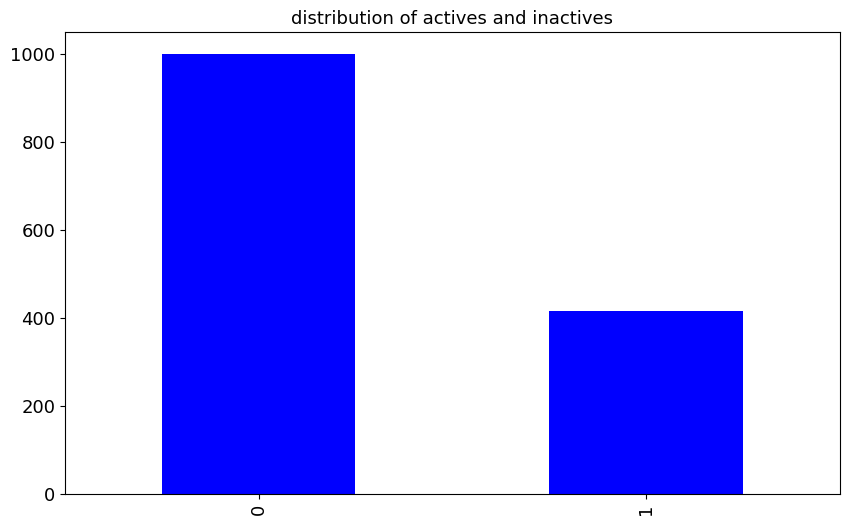

In [10]:
ax = y.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution of actives and inactives', fontsize=13)
ax.set_alpha(0.5)

In [11]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.01, random_state=42)

In [12]:
# normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_validate = pd.DataFrame(X_validate, columns=X.columns)

### Removing low variance features to improve model performance

In [13]:
from sklearn.feature_selection import VarianceThreshold


thresh = VarianceThreshold(threshold=0.03)
thresh.fit(X_train)
mask = thresh.get_support()


X_train = X_train.loc[:, mask]
X_validate = X_validate.loc[:, mask]

X_train.shape, X_validate.shape

((1400, 594), (15, 594))

In [14]:
over = SMOTE()
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

In [15]:
y_train_resampled.value_counts()

1    986
0    986
Name: activity, dtype: int64

Text(0.5, 1.0, 'distribution in sampled dataset')

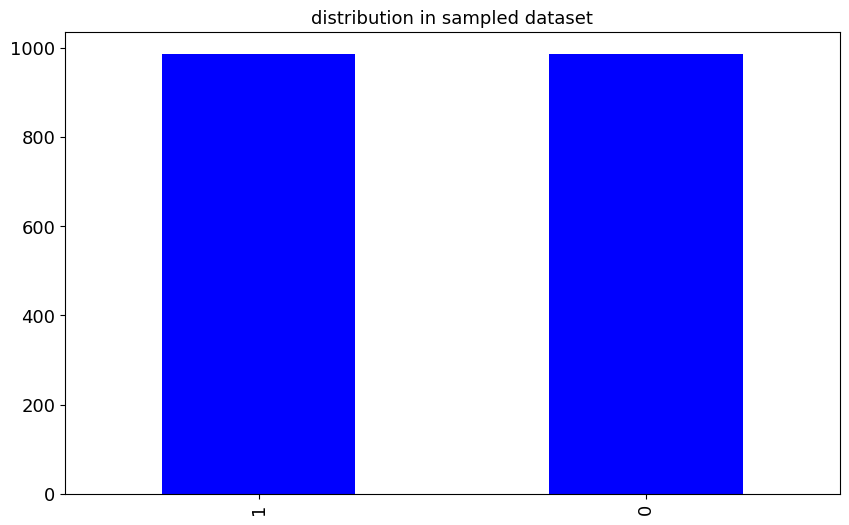

In [16]:
ax = y_train_resampled.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution in sampled dataset', fontsize=13)

## training model with oversampled data

In [17]:
model = AdaBoostClassifier()
model.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier()

### evaluating the model using the test data

In [18]:
# getting the test dataset
testing_data = pd.concat([actives_test, inactives_test], ignore_index=True)

In [19]:
len(testing_data)

600

In [20]:
testing_data['activity'].value_counts()

1    300
0    300
Name: activity, dtype: int64

In [21]:
testing_data.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,1,3,0,0,0,0,0,...,0,0,0,0,0,4.954,-0.280,0.231,3.149,1
1,1,0,0,2,2,0,0,0,0,0,...,0,1,0,0,1,5.285,-0.234,0.214,0.636,1
2,2,0,0,2,2,0,0,0,0,0,...,0,2,0,0,0,5.170,-0.658,0.444,3.317,1
3,2,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,5.170,-0.823,0.444,3.307,1
4,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,4.858,-0.717,0.000,1.820,1


In [22]:
testing_data_x = testing_data.drop(['activity'], axis=1)
print(len(testing_data_x))
testing_data_x = scaler.transform(testing_data_x)
testing_data_y = testing_data['activity']

600


In [23]:
testing_data_x = pd.DataFrame(testing_data_x, columns=X.columns)

In [24]:
testing_data_x = testing_data_x.loc[:, mask]

In [25]:
testing_data_x.head()

,D001,D002,D004,D005,D006,D012,D013,D014,D015,D016,...,D764,D765,D768,D770,D771,D773,D774,D775,D776,D777
0,-0.455695,-0.07581,0.386535,0.695019,-0.092981,-1.017572,1.425512,-1.111799,-1.203167,-1.391501,...,-0.046341,-1.730563,-0.188607,-0.661310,-0.169279,-0.120386,-0.440283,0.423037,-0.428617,0.854918
1,-0.455695,-0.07581,1.821945,-0.417012,-0.092981,0.338975,1.425512,-0.792120,-0.966054,2.264617,...,-0.046341,0.515879,-0.188607,1.150498,-0.169279,8.306624,0.543155,0.546042,-0.538212,-1.178978
2,0.812642,-0.07581,1.821945,-0.417012,-0.092981,0.565067,0.925708,-0.472440,-0.558220,-0.782148,...,-0.046341,0.515879,-0.188607,2.962306,-0.169279,-0.120386,0.201477,-0.587749,0.944543,0.990889
3,0.812642,-0.07581,1.821945,-0.417012,-0.092981,0.565067,-0.073900,-0.792120,-0.909147,-0.782148,...,-0.046341,-0.607342,-0.188607,-0.661310,-0.169279,-0.120386,0.201477,-1.028964,0.944543,0.982796
4,-1.724032,-0.07581,0.386535,-1.529042,-0.092981,-1.469755,-1.073508,0.806277,1.461983,1.045911,...,-0.046341,-1.730563,-0.188607,1.150498,-0.169279,-0.120386,-0.725510,-0.745517,-1.917818,-0.220707


In [26]:
model.predict((testing_data_x.iloc[500]).to_numpy().reshape(1, -1))

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [27]:
# converting the test dataset into a numpy array
testing_data_x = testing_data_x.to_numpy()

#### Model's accuracy on test set

In [28]:
model.score(testing_data_x, testing_data_y)

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


0.82

### evaluating model's performance with F1 score, precision, recall, etc

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [30]:
y_pred = model.predict_proba(testing_data_x)[:, 1]
y_pred_rounded = (y_pred > 0.5).astype(int)
y_pred_rounded.shape == y_pred.shape

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


True

In [31]:
testing_data_y.shape == y_pred.shape

True

In [32]:
accuracy = accuracy_score(testing_data_y, y_pred_rounded)
precision = precision_score(testing_data_y, y_pred_rounded)
recall = recall_score(testing_data_y, y_pred_rounded)
f1 = f1_score(testing_data_y, y_pred_rounded)

In [33]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.82
precision is 0.7461538461538462
recall is 0.97
f1 is 0.8434782608695651
